# Stock Portfolio Optimization using Python

In this project, I have applied Harry Markowitz's Modern Portfolio Theory to find the optimum allocation of weights of stocks one should purchase for the highest return and lowest risk. In particular I will be using Disney, Nike, Mcdonald's and IBM stocks to construct my portfolio.

Firstly, import the required libraries

In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl

%matplotlib inline 

I have used the Quandl API to get the data for the closing stock prices for each company in 2017.

In [306]:
quandl.ApiConfig.api_key = 'RcTyajz4cV-Yz5L5QHLN'

In [307]:
data = quandl.get_table('WIKI/PRICES', 
                        ticker = ['DIS', 'NKE', 'MCD', 'IBM'], 
                        qopts = { 'columns': ['date', 'ticker', 'close'] }, 
                        date = { 'gte': '2017-01-01', 'lte': '2017-12-31' },
                        paginate = True)

In [308]:
data.head()

,date,ticker,close
None,,,
0,2017-12-29,NKE,62.55
1,2017-12-28,NKE,62.95
2,2017-12-27,NKE,62.95
3,2017-12-26,NKE,63.65
4,2017-12-22,NKE,63.29


We can see from below that the data only consists of prices for 250 trading days.

In [309]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
date      1000 non-null datetime64[ns]
ticker    1000 non-null object
close     1000 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.5+ KB


I tabulated the closing stock prices for each company based on date.

In [310]:
ptable = pd.pivot_table(data,
                        index = ['date'],
                        columns = 'ticker', 
                        values = 'close')

In [311]:
ptable.head()

ticker,DIS,IBM,MCD,NKE
date,,,,
2017-01-03,106.08,167.19,119.62,51.98
2017-01-04,107.44,169.26,119.48,53.07
2017-01-05,107.38,168.70,119.70,53.06
2017-01-06,108.98,169.53,120.76,53.91
2017-01-09,108.36,167.65,120.43,53.38


Then, I have plotted a time series based graph for the table above to see a general trend of the data.

Text(0,0.5,'Closing Price ($)')

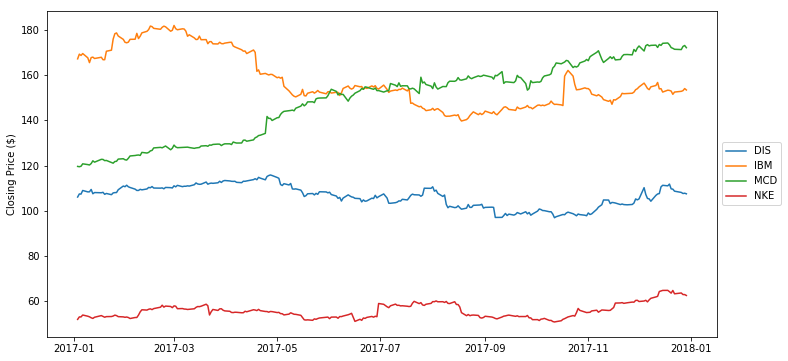

In [312]:
plt.figure(figsize=(12, 6))
for i in ptable.columns.values:
    plt.plot(ptable.index, ptable[i], label=i)
plt.legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Closing Price ($)')

With the above data, I want to plot a scatterplot for the risk vs return based on randomly generated weights. The functions below calculate the portfolio return and risk based on the weights. The portfolio return is simply a weighted sum of the daily returns from each stock. The portfolio risk is the weighted sum of the standard deviations (needs more explanation).

In [314]:
def portfolio_return(average_returns, weights):
    return np.sum(average_returns * weights) * 250

def portfolio_risk(covariance_matrix, weights):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(252)

Below are the parameters to be used

In [315]:
returns = ptable.pct_change() # daily returns
average_returns = returns.mean() # average return
covariance_matrix = returns.cov() # convariance matrix used to calculate risk
risk_free_rate = 0.0117 # US risk free rate (1 year t-bill) during 2017 | used to calculate Sharpe Ratio 
# source: https://ycharts.com/indicators/1_year_treasury_bill_rate_annual

Below is a function the generates random weights based on a speficied number of portfolios and outputs the weights as an array, as well as the return, risk and sharpe ratio based on the weights as an array. 

In [316]:
def rand_portfolios(num_portfolio, average_returns, covariance_matrix, weights, risk_free_rate):
    portfolio = np.zeros((3,num_portfolio))
    weight_array = []
    for i in range(num_portfolio):
        weights = np.random.random(4)
        weights = weights / sum(weights)
        weight_array.append(weights)
        
        preturn = portfolio_return(average_returns, weights)
        prisk = portfolio_risk(covariance_matrix, weights)
        portfolio[0, i] = preturn
        portfolio[1, i] = prisk
        portfolio[2, i] = (preturn - risk_free_rate) / prisk
    return portfolio, weight_array

Then, I have created a function to plota scatterplot of risk vs return

In [319]:
def portfolio_scatterplot(num_portfolio, average_returns, covariance_matrix, weights, risk_free_rate):
    d = rand_portfolios(num_portfolio, average_returns, covariance_matrix, weights, risk_free_rate)
    portfolio = d[0]
    weights = d[1]
    
    max_sharpe_index = np.argmax(portfolio[2])
    optimal_return = portfolio[0, max_sharpe_index]
    optimal_risk = portfolio[1, max_sharpe_index]
    optimal_weights = weights[max_sharpe_index]
    
    weights_table = pd.DataFrame(optimal_weights, index = ptable.columns[0:], columns =['Weights'])

    print('Optimal Return is: ', round(optimal_return, 3))
    print('Optimal Risk is: ',  round(optimal_risk, 3))
    print('Optimal Weights are:')
    print(weights_table)
    
    
    plt.figure(figsize=(12, 6))
    plt.scatter(portfolio[1,:], portfolio[0,:])
    plt.scatter(optimal_risk , optimal_return ,marker='X',color='r', s = 400)
    plt.xlabel('risk')
    plt.ylabel('return')


After generating 100000 random portfolios, here are the results:

Optimal Return is:  0.321
Optimal Risk is:  0.105
Optimal Weights are:
         Weights
ticker          
DIS     0.080323
IBM     0.002461
MCD     0.773468
NKE     0.143748


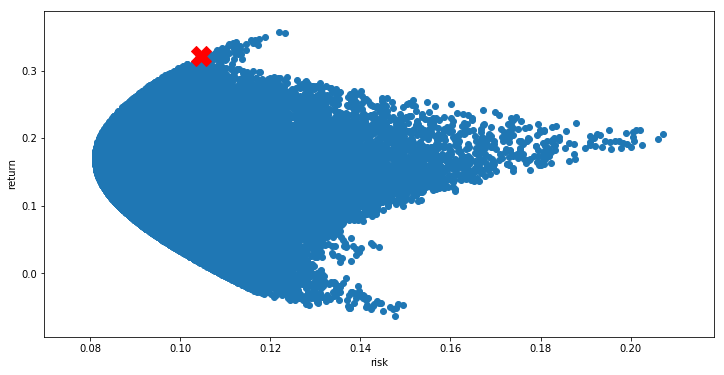

In [320]:
efficient_frontier = portfolio_scatterplot(100000, average_returns, covariance_matrix, weights, risk_free_rate)